# RL - Assignement - Text Flappy Bird

## Packages

In [1]:
# Third party imports
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
from scipy.stats import sem
from tqdm import tqdm
from pprint import pprint
import wandb

# Local imports
import gymnasium as gym
from utils.plot_utils import plot_state_values, plot_policy, plot_sum_rewards

import text_flappy_bird_gym
from utils.train import train

%matplotlib inline
%load_ext autoreload
%autoreload 2

### WandB

In [2]:
!pip install wandb -qqq

In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nicoboou. Use `wandb login --relogin` to force relogin


True

In [4]:
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'figure.figsize': [7,9]})

## Environment

In [5]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
env_info = {}

## Params

In [6]:
# Load .json config file
with open('config/one_run_config.json', 'r') as f:
    config = json.load(f)

pprint(config)

{'DeepQLearningAgent': {'BATCH_SIZE': 128,
                        'DISCOUNT': 0.99,
                        'EPSILON_DECAY': 1000,
                        'EPSILON_END': 0.05,
                        'EPSILON_START': 0.9,
                        'LR': 0.0001,
                        'NUM_ACTIONS': 2,
                        'NUM_EPISODES': 1000,
                        'POLICY': None,
                        'REPLAY_BUFFER_SIZE': 10000,
                        'SEED': 42,
                        'STATE_SIZE': 2,
                        'TAU': 0.08},
 'ExpectedSarsaAgent': {'DISCOUNT': 0.9,
                        'EPSILON': 0.1,
                        'NUM_ACTIONS': 2,
                        'NUM_EPISODES': 50000,
                        'NUM_STEPS': 500,
                        'POLICY': None,
                        'SEED': 42,
                        'STEP_SIZE': 0.1}}


## Agent 1: Expected SARSA

### Agent Init

In [7]:
from models.ExpectedSarsaAgent.expected_sarsa_agent import ExpectedSarsaAgent


In [8]:
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
all_scores = {} # Contains the scores obtained for each run
agent_info = config['ExpectedSarsaAgent']

In [9]:
agent = ExpectedSarsaAgent(config=agent_info,env=env)
all_reward_sums[agent.__class__.__name__] = []
all_state_visits[agent.__class__.__name__] = []
all_scores[agent.__class__.__name__] = []

### Training

In [10]:
agent.train(all_reward_sums, all_state_visits, all_scores)

100%|██████████| 50000/50000 [13:24<00:00, 62.16it/s]


Average Reward Sum:  109.66294
Average Score:  9.75934


average_reward_sum,▁
average_score,▁
episode_duration,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode_reward,▁▁▁▂▁▁▁▂▁▁▃█▂▂▃▂▂▂▃▁▂▂▂▁▂▁▃▃▂▁▃▄▁▂▅▂▂▁▁▃
episode_score,▁▁▁▂▁▁▁▂▁▁▂█▂▂▃▂▂▂▃▁▂▂▂▁▂▁▃▃▂▁▃▄▁▂▅▁▂▁▁▃
average_reward_sum,109.66294
average_score,9.75934
episode_duration,500
episode_reward,33
episode_score,2


### Results

In [11]:
with open('./models/ExpectedSarsaAgent/ExpectedSarsaAgent_q_values.pickle', 'rb') as handle:
    q = pickle.load(handle)

with open('./models/ExpectedSarsaAgent/ExpectedSarsaAgent_results.pickle', 'rb') as handle:
    expected_sarsa_results = pickle.load(handle)

#### Policy

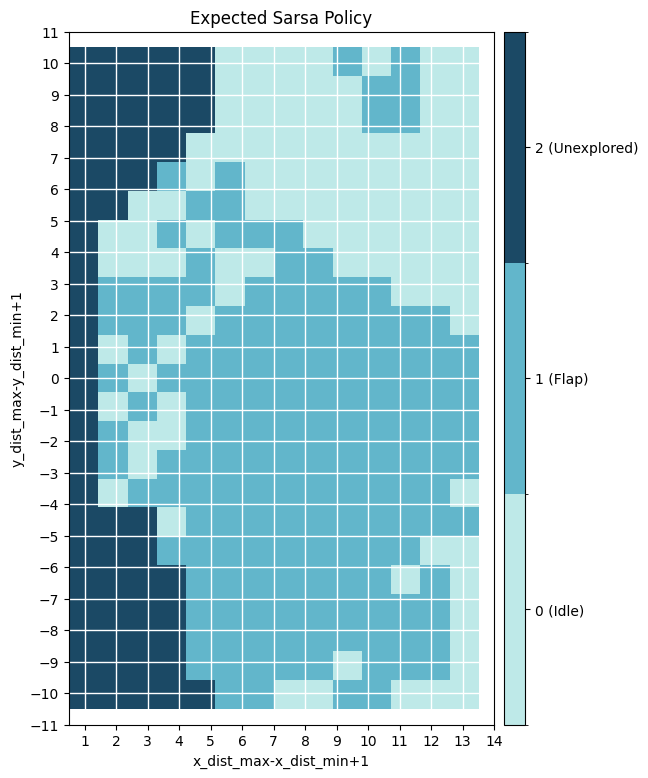

In [12]:
plot_policy(q, title="Expected Sarsa Policy")

We can clearly see here several interesting points learned from our agent and visible through its policy:
1. The agent learns to stay in the middle of the screen by **flapping when down/middle**, and stay **idle** when it is higher on the screen (see along y-axis). It seems to be a good strategy to avoid the pipes and to be ***robust***.
2. The agent learns to **flap** when it is **close to a pipe** (see along x-axis).
3. Some parts are unexplored by the agent: the **top** and **bottom** of the screen when **agent is very close to the pipe**. It seems normal, because in such cases, it is probable that the agent is dead and that the game is over. It is a good strategy to avoid **exploring** such cases, because it is a waste of time and resources.
4. The minimal distance to the pipe (x-axis = 1) is **unexplored**. Again, a normal and very **safe** strategy proposed by Expected SARSA, because it is a **deadly** situation for the agent.

#### State Value Function

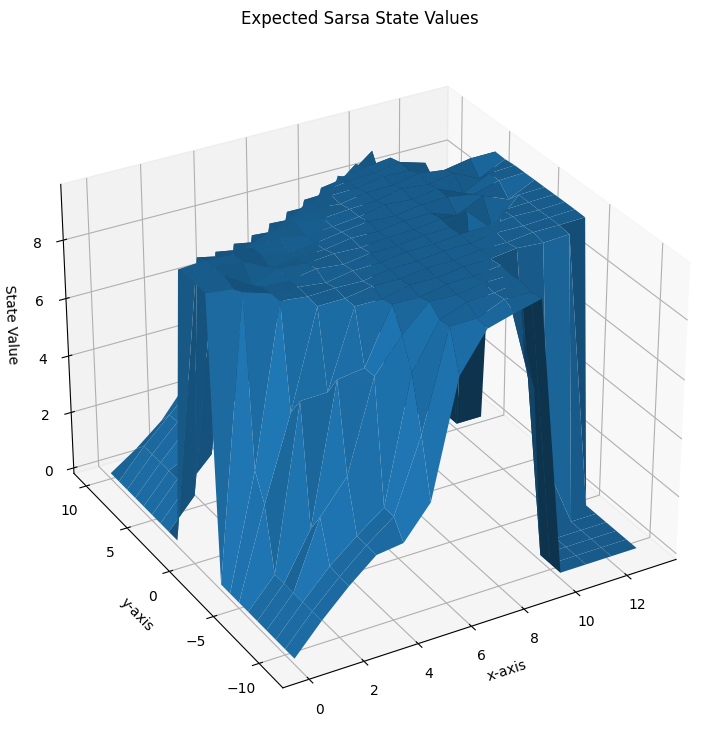

In [13]:
plot_state_values(q, title="Expected Sarsa State Values")

In this state value plot, other several interesting pieces of information can be extracted:
1. The highest state value is located in the middle of the graph, and translate to the fact that the state of being in the **middle of the screen** is the most valuable.
2. The extremeties have low state values, and translates to the fact that the states of being **very close to the pipes** (x-axis) and/or **very close to the borders of the screen (y-axis) are the least valuable.  

_N.B_: the more episodes are played, the more the agent learns and the ***smoother*** the state value function is, because it is better approximated.

#### Sum of Rewards

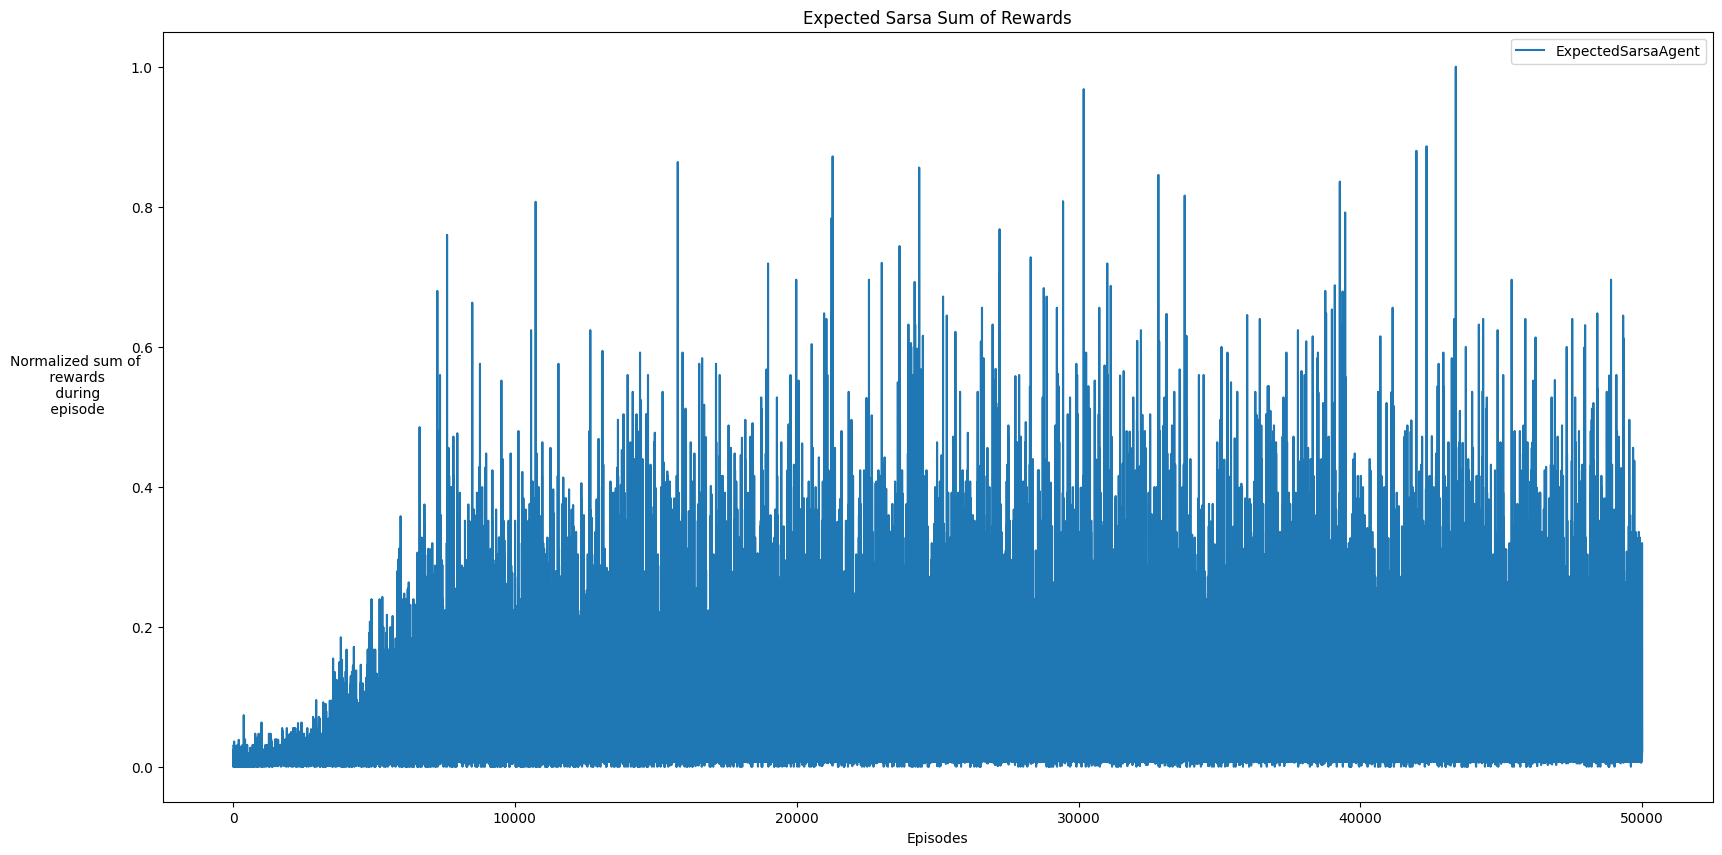

In [14]:
plot_sum_rewards(all_reward_sums, algorithms=[agent.__class__.__name__], title="Expected Sarsa Sum of Rewards")

Looking at the Normalized Sum of Rewards, we can see that the agent is learning and improving its performance. The sum of rewards is increasing, and the agent is getting better and better at playing the game. However, the learning is not linear, and the agent is not learning at the same rate at each episode. It is a good sign, because it means that the agent is learning and improving its performance, but it is not overfitting and is not learning too fast. The **exploration/exploitation tradeoff** is well managed by the agent.

## Agent 2: Deep Q-Learning

### Agent Init

In [15]:
from models.DeepQLearningAgent.dqn_agent import DeepQLearningAgent

In [16]:
agent_info = config['DeepQLearningAgent']

In [17]:
dqn_agent = DeepQLearningAgent(env, agent_info)
all_reward_sums[dqn_agent.__class__.__name__] = []
all_state_visits[dqn_agent.__class__.__name__] = []
all_scores[dqn_agent.__class__.__name__] = []

Using cpu


### Training

In [18]:
dqn_agent.train(all_reward_sums, all_state_visits, all_scores)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/nicolas/Desktop/Etudes/4_centrale_sup/CentraleSupelec/cours/centralesup_S_2/reinforcement/assignment/models/DeepQLearningAgent/dqn_agent.py:189: RuntimeWarning: Mean of empty slice.
  loss_mean = np.array(losses).mean()
/Users/nicolas/opt/anaconda3/envs/centrale_rl/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1000/1000 [08:42<00:00,  1.92it/s]

--------------------------------------------------
Average Reward Sum:  114.264
Average Score:  10.373


average_reward_sum,▁
average_score,▁
episode_duration,▁▁▁▁▂▄▅▃▇▁▂▁█▂▅▃▁▃▃▁▂▂▁▂▂▂▇▁▃▁▂▃▁▁▁▁▃▁▂▁
episode_reward,▁▁▁▁▂▄▅▃▇▁▂▁█▂▅▃▁▃▃▁▂▂▁▂▂▂▇▁▃▁▂▃▁▁▁▁▃▁▂▁
episode_score,▁▁▁▁▂▄▅▃▇▁▂▁█▂▅▃▁▃▃▁▂▂▁▂▂▂▇▁▃▁▁▃▁▁▁▁▃▁▂▁
loss,▂▁▁▂█▃▂▂▃▂▂▃▃▃▃▂▃▃▄▄▄▄▂▂▃▃█▄▅▄▂▃▅▅▄▅▅▃▂
average_reward_sum,114.264
average_score,10.373
episode_duration,316
episode_reward,316
episode_score,31


10.373

### Results

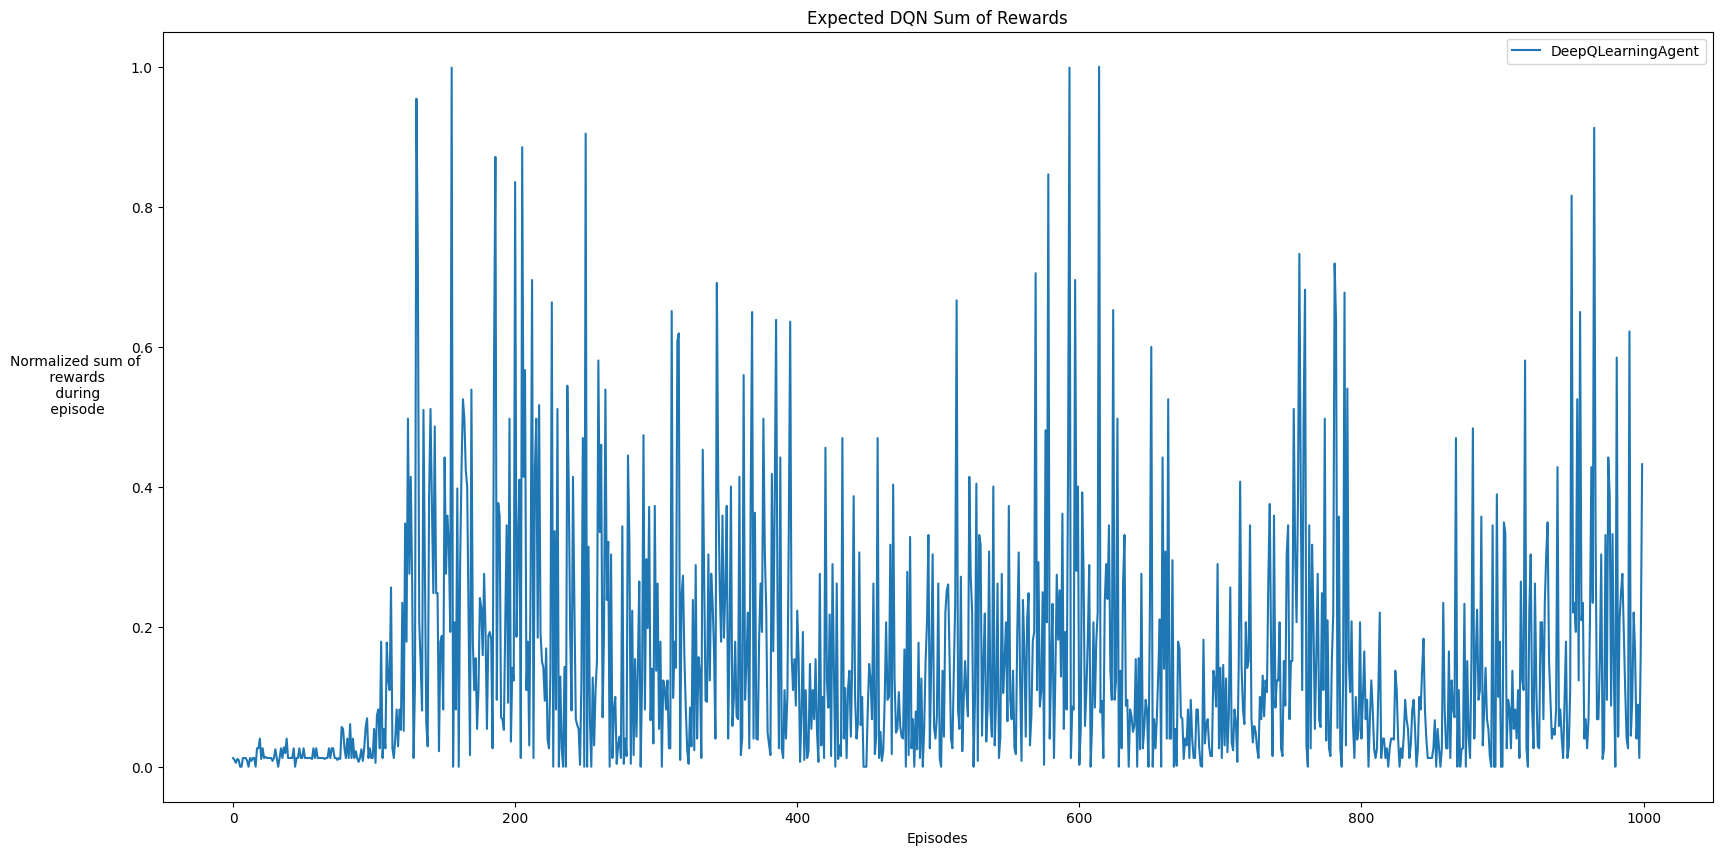

In [21]:
plot_sum_rewards(all_reward_sums, algorithms=[dqn_agent.__class__.__name__], title="Expected DQN Sum of Rewards")

Looking at the Normalized sum of Rewards for the DeepQLearning, it appears that our agent learns faster (i.e. looking at the slope of the curve) than the Expected SARSA agent. However, the peaks are not constantly increasing in the trend (compared to Expected SARSA), which denotes more exploration and more randomness in the agent's behavior. The fact that our agent is an **off-policy** learner mught explain this behavior.

## Hyperparameters Tuning

DO NOT RUN ! -> used to tune hyperparameters using sweeps

In [ ]:
# Breaks the RUN ALL button
stop()

### ExpectedSarsa

In [ ]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
env_info = {}

In [ ]:
with open('./config/sweep_config_sarsa.json', "r") as f:
    sweep_configuration = json.load(f)

In [ ]:
def objective(config):
    agent = ExpectedSarsaAgent(config=config,env=env)
    score = agent.train(all_reward_sums,all_state_visits,all_scores)
    return score

In [ ]:
def sweep():
    wandb.init()
    score = objective(wandb.config)
    wandb.log({'score': score})

In [ ]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project='Flappy-RL')
wandb.agent(sweep_id, function=sweep, count=10)

### Deep QLearning

In [ ]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
env_info = {}

In [ ]:
with open('./config/sweep_config_dqn.json', "r") as f:
    sweep_configuration = json.load(f)

In [ ]:
def objective(config):
    agent = DeepQLearningAgent(config=config,env=env)
    score = agent.train(all_reward_sums,all_state_visits,all_scores)
    return score

In [ ]:
def sweep():
    wandb.init()
    score = objective(wandb.config)
    wandb.log({'score': score})

In [ ]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project='Flappy-RL')
wandb.agent(sweep_id, function=sweep, count=10)